**Handling Imbalanced datasets**    
There are 4 commonly used methods for handling imbalanced datasets   
**Sampling methods for handling imbalance datasets**
1. Downsampling (Under sampling)
2. Upsampling (Over sampling)
3. Upweighting
4. Combination of over- and under-sampling

1.**Downsampling(Under sampling):**  
 In this the classes are balanced by performing resampling on majority class. It reduces the size of majority class in order to match with the size of the minority class.
 There are different methods to perform this sampling. one of those method is Random Under sampler, which selectes a subset of data randomly to balance the data in target classes.

2.**Upsampling (Over sampling):**
  This method is used when there is an insufficient data. In this the resampling performed on minority class. It increases the size of the minority class in order to match with the size   of the majority class.One best example of this sampling is SMOTE (Synthetic minority over sampling Technique).It works by creating synthetic samples from the minor class to balance the   data in target classes.
  
3.**Upweighting:**
  Here the classes are balanced by scaling the weight of minority class. This weight is scaled by taking the ratio of number of samples in majority class to the number of samples in       minority class. A minority class weight of 30 (say) means the model treats the minority class as 30 times as important as it would majority class of weight 1. 
  
 Generally these 3 methods are most widely used to handle imbalanced data in building ML models. For DL models there is a separate batch generator to handle highly imbalanced data.
 
 For more details about sampling methods, please check below link,  
 https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.over_sampling
 

In [1]:
predictors = []



def do_next_Click(df,agg_suffix='nextClick', agg_type='float32'):
    
    
    GROUP_BY_NEXT_CLICKS = [
    
    # V1
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device', 'app']}, 
    {'groupby': ['device', 'channel']},
    {'groupby': ['app', 'device', 'channel']},
    ]
    
    for spec in GROUP_BY_NEXT_CLICKS:
    
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
        all_features = spec['groupby'] + ['click_time']
        df[new_feature] = (df[all_features].groupby(spec[
            'groupby']).click_time.shift(-1) - df.click_time).dt.seconds.astype(agg_type)
        print('added')
        predictors.append(new_feature)
    return (df)

def do_prev_Click(df,agg_suffix='prevClick', agg_type='float32'):

    
    GROUP_BY_NEXT_CLICKS = [
        
     {'groupby': ['ip', 'os']},
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
      {'groupby': ['ip', 'os', 'device']},  
    ]

    for spec in GROUP_BY_NEXT_CLICKS:
    
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        all_features = spec['groupby'] + ['click_time']

        df[new_feature] = (df.click_time - df[all_features].groupby(spec[
                'groupby']).click_time.shift(+1) ).dt.seconds.astype(agg_type)
        print('added')
        predictors.append(new_feature)
    return (df)    


def do_count( df, group_cols, agg_type='uint16', show_max=False, show_agg=True ):
    agg_name='{}count'.format('_'.join(group_cols))  
    if show_agg:
        print( "\nAggregating by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
    return( df )
    
##  Below a function is written to extract unique count feature from different cols
def do_countuniq( df, group_cols, counted, agg_type='uint8', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)

    return( df )
### Below a function is written to extract cumulative count feature  from different cols    
def do_cumcount( df, group_cols, counted,agg_type='uint16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_cumcount'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCumulative count by ", group_cols , '... and saved in', agg_name  )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
    return( df )


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def todatetime(df):
    df['click_time']=pd.to_datetime(df['click_time'])
    df['click_hour']=df['click_time'].dt.hour
    df['click_day']=df['click_time'].dt.day
    return df

In [5]:
test = pd.read_csv('data/test.csv')
test

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00
...,...,...,...,...,...,...,...
18790464,18790464,99442,9,1,13,127,2017-11-10 15:00:00
18790465,18790465,88046,23,1,37,153,2017-11-10 15:00:00
18790466,18790467,81398,18,1,17,265,2017-11-10 15:00:00
18790467,18790466,123236,27,1,13,122,2017-11-10 15:00:00


In [7]:
pd.read_csv('data/train.csv', nrows=1800000, skiprows=range(1,180000000))

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,37363,12,1,25,245,2017-11-06 20:27:57,NaN,0
1,89913,2,1,9,469,2017-11-06 20:27:57,NaN,0
2,114235,26,1,13,121,2017-11-06 20:27:57,NaN,0
3,18839,3,1,19,442,2017-11-06 20:27:57,NaN,0
4,105580,15,1,13,245,2017-11-06 20:27:57,NaN,0
...,...,...,...,...,...,...,...,...
1799995,50482,8,1,19,145,2017-11-06 22:55:00,NaN,0
1799996,62171,9,1,40,215,2017-11-06 22:55:00,NaN,0
1799997,138852,26,1,19,121,2017-11-06 22:55:00,NaN,0
1799998,114923,26,1,19,121,2017-11-06 22:55:00,NaN,0


In [4]:
train_no_dup = pd.DataFrame()

for i in range(30):
    print(i)
    k = 5000000
    t = pd.read_csv('train.csv', nrows=1800000, skiprows=range(1, k*i))
    t=todatetime(t)
    t = t.drop(['attributed_time'],axis=1)

    t['app'] = t['app'].astype('str') 
    t['device'] = t['device'].astype('str') 
    t['os'] = t['os'].astype('str') 
    t['ip'] = t['ip'].astype('str') 
    t['channel'] = t['channel'].astype('str') 
    
    
    
    t = do_prev_Click(t ,agg_suffix='prevClick', agg_type='float32');
    t = do_next_Click(t ,agg_suffix='nextClick', agg_type='float32');
    t =do_countuniq( t, ['ip'], 'channel' );
    t = do_countuniq( t, ['ip', 'device', 'os'], 'app'); 
    t = do_countuniq( t, ['ip', 'click_day'], 'click_hour' );
    t = do_countuniq( t, ['ip'], 'app'); 
    t = do_countuniq( t, ['ip', 'app'], 'os'); 
    t = do_countuniq( t, ['ip'], 'device'); 
    t = do_countuniq( t, ['app'], 'channel'); 
    t = do_cumcount( t, ['ip'], 'os'); 
    t = do_cumcount( t, ['ip', 'device', 'os'], 'app'); 
    t = do_count( t, ['ip', 'click_day', 'click_hour'] ); 
    t = do_count( t, ['ip', 'app']); 
    t = do_count( t, ['ip', 'app', 'os']);
    
    train_no_dup = pd.concat([train_no_dup, t])
    
    lst = [t]
    del lst
    
    
    

0
added
added
added
added
added
added

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  click_hour  by  ['ip', 'click_day'] ... and saved in ip_click_day_by_click_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq

Cumulative count by  ['ip'] ... and saved in ip_by_os_cumcount

Cumulative count by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_cumcount

Aggregating by  ['ip', 'click_day', 'click_hour'] ... and saved in ip_click_day_click_hourcount

Aggregating by  ['ip', 'app'] ... and saved in ip_appcount

Aggregating by  ['ip', 'app', 'os'] ... and saved in ip_


Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  click_hour  by  ['ip', 'click_day'] ... and saved in ip_click_day_by_click_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq

Cumulative count by  ['ip'] ... and saved in ip_by_os_cumcount

Cumulative count by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_cumcount

Aggregating by  ['ip', 'click_day', 'click_hour'] ... and saved in ip_click_day_click_hourcount

Aggregating by  ['ip', 'app'] ... and saved in ip_appcount

Aggregating by  ['ip', 'app', 'os'] ... and saved in ip_app_oscount
9
added
added
added
added
added
added

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channe


Counting unqiue  click_hour  by  ['ip', 'click_day'] ... and saved in ip_click_day_by_click_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq

Cumulative count by  ['ip'] ... and saved in ip_by_os_cumcount

Cumulative count by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_cumcount

Aggregating by  ['ip', 'click_day', 'click_hour'] ... and saved in ip_click_day_click_hourcount

Aggregating by  ['ip', 'app'] ... and saved in ip_appcount

Aggregating by  ['ip', 'app', 'os'] ... and saved in ip_app_oscount
17
added
added
added
added
added
added

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_a


Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq

Cumulative count by  ['ip'] ... and saved in ip_by_os_cumcount

Cumulative count by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_cumcount

Aggregating by  ['ip', 'click_day', 'click_hour'] ... and saved in ip_click_day_click_hourcount

Aggregating by  ['ip', 'app'] ... and saved in ip_appcount

Aggregating by  ['ip', 'app', 'os'] ... and saved in ip_app_oscount
25
added
added
added
added
added
added

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  click_hour  by  ['ip', 'click_day'] ... and saved in ip_click_day_by_click_ho


Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq

Cumulative count by  ['ip'] ... and saved in ip_by_os_cumcount

Cumulative count by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_cumcount

Aggregating by  ['ip', 'click_day', 'click_hour'] ... and saved in ip_click_day_click_hourcount

Aggregating by  ['ip', 'app'] ... and saved in ip_appcount

Aggregating by  ['ip', 'app', 'os'] ... and saved in ip_app_oscount
33
added
added
added
added
added
added

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  click_hour  by  ['ip', 'click_day'] ... and saved in ip_click_day_by_click_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_

In [ ]:
train_no_dup = train_no_dup.sample(frac=1).reset_index(drop=True)

In [ ]:
train_val = train_no_dup[:500000]

In [ ]:
train_data = train_no_dup[500000:]

In [ ]:
lst = [train_no_dup]
del lst

In [ ]:
positive = train_data[train_data.is_attributed==1]

In [ ]:
k = 10000000
zero = train_data[-k:]
negative = zero[zero.is_attributed==0].sample(int(positive.shape[0]*2))

lst = [zero]
del lst

In [ ]:
df = pd.concat([train_val, positive, negative])

lst = [train_val, positive, negative]
del lst

In [ ]:
df = df.drop(['click_time'],axis=1)
df = df.drop(['click_day'],axis=1)

1,0- в основном кликают

**Distribution of classes in train dataset before sampling**

**Classes:**  
0- User will not download an app after clicking a mobile app advertisement    
1- User will download an app after clicking a mobile app advertisement

**Split the dataset into train & test sets**

In [ ]:
val = df[df.index < 500000]
training =  df[df.index > 500000]

In [4]:
training = pd.read_csv('1.csv').drop(columns='Unnamed: 0')
val = pd.read_csv('2.csv').drop(columns='Unnamed: 0')
val.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'click_hour',
       'ip_os_prevClick', 'ip_app_device_os_channel_prevClick',
       'ip_os_device_prevClick', 'ip_app_nextClick', 'ip_os_nextClick',
       'ip_app_device_os_channel_nextClick', 'ip_os_device_app_nextClick',
       'device_channel_nextClick', 'app_device_channel_nextClick',
       'ip_by_channel_countuniq', 'ip_device_os_by_app_countuniq',
       'ip_click_day_by_click_hour_countuniq', 'ip_by_app_countuniq',
       'ip_app_by_os_countuniq', 'ip_by_device_countuniq',
       'app_by_channel_countuniq', 'ip_by_os_cumcount',
       'ip_device_os_by_app_cumcount', 'ip_click_day_click_hourcount',
       'ip_appcount', 'ip_app_oscount'],
      dtype='object')

In [5]:
x_train.columns
training[['ip_os_prevClick',
       'ip_app_device_os_channel_prevClick', 'ip_os_device_prevClick',
       'ip_app_nextClick', 'ip_os_nextClick',
       'ip_app_device_os_channel_nextClick', 'ip_os_device_app_nextClick',
       'device_channel_nextClick', 'app_device_channel_nextClick']] = training[['ip_os_prevClick',
       'ip_app_device_os_channel_prevClick', 'ip_os_device_prevClick',
       'ip_app_nextClick', 'ip_os_nextClick',
       'ip_app_device_os_channel_nextClick', 'ip_os_device_app_nextClick',
       'device_channel_nextClick', 'app_device_channel_nextClick']].fillna(100000000000)
training[['ip_by_channel_countuniq', 'ip_device_os_by_app_countuniq',
       'ip_click_day_by_click_hour_countuniq', 'ip_by_app_countuniq',
       'ip_app_by_os_countuniq', 'ip_by_device_countuniq',
       'app_by_channel_countuniq', 'ip_by_os_cumcount',
       'ip_device_os_by_app_cumcount', 'ip_click_day_click_hourcount',
       'ip_appcount', 'ip_app_oscount']] = training[['ip_by_channel_countuniq', 'ip_device_os_by_app_countuniq',
       'ip_click_day_by_click_hour_countuniq', 'ip_by_app_countuniq',
       'ip_app_by_os_countuniq', 'ip_by_device_countuniq',
       'app_by_channel_countuniq', 'ip_by_os_cumcount',
       'ip_device_os_by_app_cumcount', 'ip_click_day_click_hourcount',
       'ip_appcount', 'ip_app_oscount']].fillna(0)
training

NameError: name 'x_train' is not defined

In [89]:
training = pd.concat([training, training[training['is_attributed']==1]])

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(training.drop('is_attributed', axis=1),
                                               training['is_attributed'],
                                               test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(881848, 27) (881848,)
(220463, 27) (220463,)


In [7]:
from catboost import Pool, CatBoostClassifier
from scipy.stats import randint

training['app'] = training['app'].astype('category') 
training['device'] = training['device'].astype('category') 
training['os'] = training['os'].astype('category') 
training['ip'] = training['ip'].astype('category') 
training['channel'] = training['channel'].astype('category') 
training['click_hour'] = training['click_hour'].astype('category') 


val['app'] = val['app'].astype('category') 
val['device'] = val['device'].astype('category') 
val['os'] = val['os'].astype('category') 
val['ip'] = val['ip'].astype('category') 
val['channel'] = val['channel'].astype('category') 
val['click_hour'] = val['click_hour'].astype('category')
from sklearn.model_selection import RandomizedSearchCV
clf = CatBoostClassifier()
# param_dist = { 
#     "learning_rate": np.linspace(0,0.2,5),
#                "max_depth": randint(3, 10)}
               
# #Instantiate RandomSearchCV object
# rscv = RandomizedSearchCV(clf , param_dist, scoring='roc_auc', cv =5)

#Fit the model
rscv.fit(x_train, y_train, cat_features=[0,1,2,3,4,5])


Learning rate set to 0.186474
0:	learn: 0.4460102	total: 1.06s	remaining: 17m 38s
1:	learn: 0.3157734	total: 2.06s	remaining: 17m 9s
2:	learn: 0.2507275	total: 2.64s	remaining: 14m 38s
3:	learn: 0.2169416	total: 3.46s	remaining: 14m 21s
4:	learn: 0.1976498	total: 4.16s	remaining: 13m 48s
5:	learn: 0.1854243	total: 5.02s	remaining: 13m 52s
6:	learn: 0.1772839	total: 5.63s	remaining: 13m 18s
7:	learn: 0.1704549	total: 6.28s	remaining: 12m 58s
8:	learn: 0.1667750	total: 6.94s	remaining: 12m 44s
9:	learn: 0.1642524	total: 7.63s	remaining: 12m 35s
10:	learn: 0.1622136	total: 8.15s	remaining: 12m 12s
11:	learn: 0.1603244	total: 8.72s	remaining: 11m 57s
12:	learn: 0.1586475	total: 9.21s	remaining: 11m 39s
13:	learn: 0.1569216	total: 9.84s	remaining: 11m 32s
14:	learn: 0.1558592	total: 10.6s	remaining: 11m 36s
15:	learn: 0.1549153	total: 11.5s	remaining: 11m 49s
16:	learn: 0.1540079	total: 12.3s	remaining: 11m 51s
17:	learn: 0.1532933	total: 12.9s	remaining: 11m 41s
18:	learn: 0.1526106	total:

153:	learn: 0.1359602	total: 1m 59s	remaining: 10m 53s
154:	learn: 0.1359367	total: 1m 59s	remaining: 10m 52s
155:	learn: 0.1359077	total: 2m	remaining: 10m 52s
156:	learn: 0.1358851	total: 2m 1s	remaining: 10m 50s
157:	learn: 0.1358233	total: 2m 1s	remaining: 10m 49s
158:	learn: 0.1358158	total: 2m 2s	remaining: 10m 47s
159:	learn: 0.1357792	total: 2m 3s	remaining: 10m 46s
160:	learn: 0.1357584	total: 2m 3s	remaining: 10m 45s
161:	learn: 0.1357280	total: 2m 4s	remaining: 10m 44s
162:	learn: 0.1356970	total: 2m 5s	remaining: 10m 43s
163:	learn: 0.1356722	total: 2m 6s	remaining: 10m 42s
164:	learn: 0.1356229	total: 2m 6s	remaining: 10m 41s
165:	learn: 0.1356013	total: 2m 7s	remaining: 10m 40s
166:	learn: 0.1355878	total: 2m 8s	remaining: 10m 39s
167:	learn: 0.1355768	total: 2m 8s	remaining: 10m 38s
168:	learn: 0.1355395	total: 2m 9s	remaining: 10m 37s
169:	learn: 0.1355036	total: 2m 10s	remaining: 10m 37s
170:	learn: 0.1354799	total: 2m 11s	remaining: 10m 36s
171:	learn: 0.1354490	total

305:	learn: 0.1325131	total: 3m 53s	remaining: 8m 49s
306:	learn: 0.1324982	total: 3m 54s	remaining: 8m 49s
307:	learn: 0.1324753	total: 3m 55s	remaining: 8m 48s
308:	learn: 0.1324601	total: 3m 56s	remaining: 8m 48s
309:	learn: 0.1324476	total: 3m 57s	remaining: 8m 47s
310:	learn: 0.1324367	total: 3m 57s	remaining: 8m 46s
311:	learn: 0.1324134	total: 3m 58s	remaining: 8m 46s
312:	learn: 0.1324056	total: 3m 59s	remaining: 8m 45s
313:	learn: 0.1323857	total: 4m	remaining: 8m 44s
314:	learn: 0.1323687	total: 4m 1s	remaining: 8m 44s
315:	learn: 0.1323530	total: 4m 1s	remaining: 8m 43s
316:	learn: 0.1323456	total: 4m 2s	remaining: 8m 42s
317:	learn: 0.1323348	total: 4m 3s	remaining: 8m 41s
318:	learn: 0.1323259	total: 4m 3s	remaining: 8m 40s
319:	learn: 0.1322921	total: 4m 4s	remaining: 8m 40s
320:	learn: 0.1322780	total: 4m 5s	remaining: 8m 39s
321:	learn: 0.1322633	total: 4m 6s	remaining: 8m 38s
322:	learn: 0.1322417	total: 4m 6s	remaining: 8m 37s
323:	learn: 0.1322306	total: 4m 7s	remain

458:	learn: 0.1305238	total: 5m 50s	remaining: 6m 53s
459:	learn: 0.1305187	total: 5m 51s	remaining: 6m 53s
460:	learn: 0.1305030	total: 5m 52s	remaining: 6m 52s
461:	learn: 0.1304891	total: 5m 53s	remaining: 6m 51s
462:	learn: 0.1304745	total: 5m 54s	remaining: 6m 50s
463:	learn: 0.1304595	total: 5m 55s	remaining: 6m 50s
464:	learn: 0.1304483	total: 5m 55s	remaining: 6m 49s
465:	learn: 0.1304313	total: 5m 56s	remaining: 6m 48s
466:	learn: 0.1304045	total: 5m 57s	remaining: 6m 48s
467:	learn: 0.1303891	total: 5m 58s	remaining: 6m 47s
468:	learn: 0.1303704	total: 5m 58s	remaining: 6m 46s
469:	learn: 0.1303590	total: 5m 59s	remaining: 6m 45s
470:	learn: 0.1303480	total: 6m	remaining: 6m 45s
471:	learn: 0.1303336	total: 6m 1s	remaining: 6m 44s
472:	learn: 0.1303277	total: 6m 2s	remaining: 6m 43s
473:	learn: 0.1303043	total: 6m 3s	remaining: 6m 43s
474:	learn: 0.1302864	total: 6m 4s	remaining: 6m 42s
475:	learn: 0.1302530	total: 6m 5s	remaining: 6m 41s
476:	learn: 0.1302509	total: 6m 5s	re

611:	learn: 0.1288819	total: 7m 52s	remaining: 4m 59s
612:	learn: 0.1288653	total: 7m 52s	remaining: 4m 58s
613:	learn: 0.1288585	total: 7m 53s	remaining: 4m 57s
614:	learn: 0.1288402	total: 7m 54s	remaining: 4m 57s
615:	learn: 0.1288286	total: 7m 55s	remaining: 4m 56s
616:	learn: 0.1288160	total: 7m 56s	remaining: 4m 55s
617:	learn: 0.1288107	total: 7m 56s	remaining: 4m 54s
618:	learn: 0.1287957	total: 7m 57s	remaining: 4m 53s
619:	learn: 0.1287846	total: 7m 58s	remaining: 4m 53s
620:	learn: 0.1287796	total: 7m 59s	remaining: 4m 52s
621:	learn: 0.1287690	total: 8m	remaining: 4m 51s
622:	learn: 0.1287575	total: 8m	remaining: 4m 51s
623:	learn: 0.1287489	total: 8m 1s	remaining: 4m 50s
624:	learn: 0.1287383	total: 8m 2s	remaining: 4m 49s
625:	learn: 0.1287324	total: 8m 3s	remaining: 4m 48s
626:	learn: 0.1287153	total: 8m 4s	remaining: 4m 48s
627:	learn: 0.1287039	total: 8m 4s	remaining: 4m 47s
628:	learn: 0.1286858	total: 8m 5s	remaining: 4m 46s
629:	learn: 0.1286746	total: 8m 6s	remaini

764:	learn: 0.1273368	total: 10m 11s	remaining: 3m 7s
765:	learn: 0.1273182	total: 10m 12s	remaining: 3m 7s
766:	learn: 0.1273026	total: 10m 13s	remaining: 3m 6s
767:	learn: 0.1272935	total: 10m 14s	remaining: 3m 5s
768:	learn: 0.1272822	total: 10m 15s	remaining: 3m 4s
769:	learn: 0.1272774	total: 10m 16s	remaining: 3m 4s
770:	learn: 0.1272689	total: 10m 18s	remaining: 3m 3s
771:	learn: 0.1272587	total: 10m 18s	remaining: 3m 2s
772:	learn: 0.1272513	total: 10m 19s	remaining: 3m 2s
773:	learn: 0.1272437	total: 10m 21s	remaining: 3m 1s
774:	learn: 0.1272275	total: 10m 22s	remaining: 3m
775:	learn: 0.1272074	total: 10m 23s	remaining: 2m 59s
776:	learn: 0.1271979	total: 10m 24s	remaining: 2m 59s
777:	learn: 0.1271850	total: 10m 25s	remaining: 2m 58s
778:	learn: 0.1271686	total: 10m 26s	remaining: 2m 57s
779:	learn: 0.1271686	total: 10m 27s	remaining: 2m 56s
780:	learn: 0.1271543	total: 10m 28s	remaining: 2m 56s
781:	learn: 0.1271488	total: 10m 29s	remaining: 2m 55s
782:	learn: 0.1271361	to

915:	learn: 0.1259396	total: 12m 31s	remaining: 1m 8s
916:	learn: 0.1259368	total: 12m 32s	remaining: 1m 8s
917:	learn: 0.1259284	total: 12m 33s	remaining: 1m 7s
918:	learn: 0.1259251	total: 12m 34s	remaining: 1m 6s
919:	learn: 0.1259167	total: 12m 35s	remaining: 1m 5s
920:	learn: 0.1259167	total: 12m 36s	remaining: 1m 4s
921:	learn: 0.1259043	total: 12m 37s	remaining: 1m 4s
922:	learn: 0.1258968	total: 12m 38s	remaining: 1m 3s
923:	learn: 0.1258795	total: 12m 39s	remaining: 1m 2s
924:	learn: 0.1258705	total: 12m 40s	remaining: 1m 1s
925:	learn: 0.1258613	total: 12m 41s	remaining: 1m
926:	learn: 0.1258497	total: 12m 42s	remaining: 1m
927:	learn: 0.1258497	total: 12m 43s	remaining: 59.3s
928:	learn: 0.1258348	total: 12m 44s	remaining: 58.5s
929:	learn: 0.1258220	total: 12m 45s	remaining: 57.6s
930:	learn: 0.1258086	total: 12m 46s	remaining: 56.8s
931:	learn: 0.1257960	total: 12m 47s	remaining: 56s
932:	learn: 0.1257853	total: 12m 48s	remaining: 55.2s
933:	learn: 0.1257768	total: 12m 49s

In [8]:
tuned_clf = clf

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

print('ROC AUC score: {}'.format(roc_auc_score(y_test, tuned_clf.predict_proba(x_test)[:, 1])))
print(classification_report(y_test, tuned_clf.predict(x_test)))
print('APS score: {}'.format(average_precision_score(y_test, tuned_clf.predict_proba(x_test)[:, 1])))


from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, tuned_clf.predict(x_test))

ROC AUC score: 0.9851990420841761
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    147093
           1       0.96      0.90      0.93     73370

    accuracy                           0.95    220463
   macro avg       0.96      0.94      0.95    220463
weighted avg       0.95      0.95      0.95    220463

APS score: 0.9780987839135565


array([[144393,   2700],
       [  7648,  65722]])

In [10]:
x = val.drop('is_attributed', axis=1)
y = val['is_attributed']

In [11]:
p = tuned_clf.predict_proba(x)[:, 1]
y_preds = tuned_clf.predict(x)

In [12]:
print('ROC AUC score: {}'.format(roc_auc_score(y, p)))
print(classification_report(y, y_preds))
print('APS score: {}'.format(average_precision_score(y, p)))

ROC AUC score: 0.9858153270535001
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    498762
           1       0.10      0.90      0.19      1238

    accuracy                           0.98    500000
   macro avg       0.55      0.94      0.59    500000
weighted avg       1.00      0.98      0.99    500000

APS score: 0.7243867295231213


In [13]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
tr = []
f1 = []

for i in np.linspace(0.96, 1, 100):
    tr.append(i)
    f1.append(f1_score(y, p>i, average='binary'))



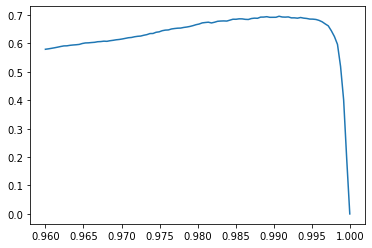

In [14]:
plt.plot(tr,f1);

In [15]:
max(f1)

0.6956115779645192

In [16]:
opt_tr = tr[np.argmax(f1)]

In [17]:
print('ROC AUC score: {}'.format(roc_auc_score(y, p)))
print(classification_report(y, p>opt_tr))
print('APS score: {}'.format(average_precision_score(y, p)))

confusion_matrix(y, p>opt_tr)

ROC AUC score: 0.9858153270535001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    498762
           1       0.82      0.60      0.70      1238

    accuracy                           1.00    500000
   macro avg       0.91      0.80      0.85    500000
weighted avg       1.00      1.00      1.00    500000

APS score: 0.7243867295231213


array([[498603,    159],
       [   493,    745]])

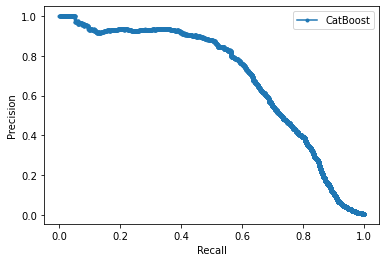

In [107]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y, p)
pyplot.plot(recall, precision, marker='.', label='СatBoost')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

<AxesSubplot:>

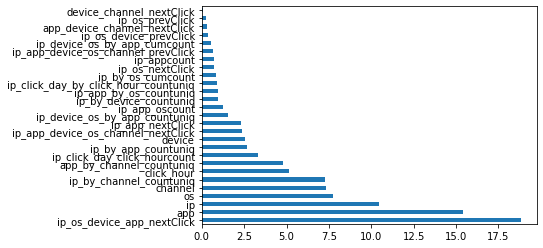

In [108]:
feat_importances = pd.Series(tuned_clf.feature_importances_, index=x.columns)
feat_importances.nlargest(40).plot(kind='barh')

In [80]:
#Original LGB model before sampling
num_round=200
def lgb_basemodel(x_train,y_train):
    model = lgb.LGBMClassifier(params,num_round, early_stopping_rounds=20, valid_sets=validation_data)
    model=lgb.train(params,train_data,num_round,valid_sets=validation_data,early_stopping_rounds=20)
#     model.fit(x_train, y_train)
    return model

In [81]:
from imblearn.under_sampling import RandomUnderSampler 
import lightgbm as lgb

params={ 'num_leaves':200,
        'objective':'binary',
        'metric':['auc','binary_logloss']
       }

def lgb_downsampling_train(x_train,y_train):
    lgb_enn=RandomUnderSampler(random_state=42)
    x_resample,y_resample=lgb_enn.fit_resample(x_train,y_train)
    train_data=lgb.Dataset(x_resample,label=y_resample,free_raw_data=False)
    lgb_model=lgb.train(params,train_data,num_round,valid_sets=validation_data,early_stopping_rounds=20)
    return lgb_model,x_resample,y_resample;

In [82]:
x

,ip,app,device,os,channel,click_hour,ip_os_prevClick,ip_app_device_os_channel_prevClick,ip_os_device_prevClick,ip_app_nextClick,...,ip_click_day_by_click_hour_countuniq,ip_by_app_countuniq,ip_app_by_os_countuniq,ip_by_device_countuniq,app_by_channel_countuniq,ip_by_os_cumcount,ip_device_os_by_app_cumcount,ip_click_day_click_hourcount,ip_appcount,ip_app_oscount
0,67037,3,1,16,130,17,4.0,NaN,4.0,1207.0,...,5,33,18,4,36,532,11,222,105,4
1,259464,9,1,19,127,1,4.0,NaN,4.0,NaN,...,3,17,1,2,34,77,43,84,4,4
2,69714,6,1,13,459,0,NaN,NaN,NaN,2951.0,...,2,14,2,1,4,0,0,21,2,1
3,78529,8,1,19,145,12,1.0,1.0,1.0,41.0,...,2,18,2,1,3,19,4,64,7,6
4,334560,18,1,13,439,0,5.0,1151.0,5.0,NaN,...,1,15,1,1,11,25,24,17,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,60428,15,1,19,315,22,1.0,47.0,1.0,443.0,...,7,25,11,3,25,186,32,98,25,5
499996,32206,7,1,17,101,10,25.0,25.0,25.0,445.0,...,3,19,4,2,1,52,2,95,11,7
499997,85420,23,1,10,153,4,16.0,43.0,16.0,NaN,...,2,15,1,2,6,33,26,57,2,2
499998,26879,20,1,19,259,13,0.0,NaN,0.0,3.0,...,2,20,2,3,5,44,3,136,6,2


In [83]:
#load datasets in lgb formate
train_data=lgb.Dataset(x_train,label=y_train,free_raw_data=False, categorical_feature = ['ip','app','os','channel', 'device', 'click_hour'])
validation_data=lgb.Dataset(x,label=y,free_raw_data=False,  categorical_feature = ['ip','app','os','channel', 'device', 'click_hour'] )

lgb_downsampling=lgb_downsampling_train(x_train,y_train)

/Users/anastasiagavrilova/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 294067, number of negative: 294067
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21612
[LightGBM] [Info] Number of data points in the train set: 588134, number of used features: 27


/Users/anastasiagavrilova/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/anastasiagavrilova/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	valid_0's auc: 0.950313	valid_0's binary_logloss: 0.611638
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.952948	valid_0's binary_logloss: 0.54546
[3]	valid_0's auc: 0.952916	valid_0's binary_logloss: 0.489969
[4]	valid_0's auc: 0.953777	valid_0's binary_logloss: 0.443136
[5]	valid_0's auc: 0.953356	valid_0's binary_logloss: 0.401613
[6]	valid_0's auc: 0.953644	valid_0's binary_logloss: 0.365319
[7]	valid_0's auc: 0.962473	valid_0's binary_logloss: 0.334215
[8]	valid_0's auc: 0.963838	valid_0's binary_logloss: 0.306703
[9]	valid_0's auc: 0.964718	valid_0's binary_logloss: 0.282436
[10]	valid_0's auc: 0.964081	valid_0's binary_logloss: 0.25983
[11]	valid_0's auc: 0.964647	valid_0's binary_logloss: 0.240249
[12]	valid_0's auc: 0.965911	valid_0's binary_logloss: 0.224535
[13]	valid_0's auc: 0.966693	valid_0's binary_logloss: 0.209299
[14]	valid_0's auc: 0.967082	valid_0's 

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
cm_base=classification_report(y,  xgost>0.995)
print(cm_base)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    498762
           1       0.72      0.59      0.65      1238

    accuracy                           1.00    500000
   macro avg       0.86      0.80      0.82    500000
weighted avg       1.00      1.00      1.00    500000



In [39]:
xgost = lgb_downsampling[0].predict(x)

In [43]:
pd.DataFrame({'y':xgost}).to_csv('lgbt')

<AxesSubplot:>

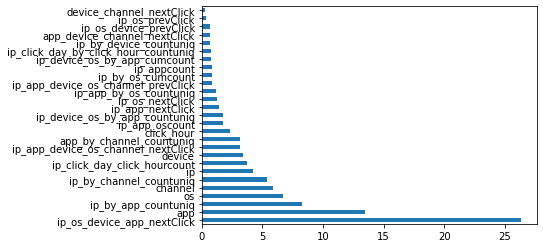

In [77]:
feat_importances = pd.Series(tuned_clf.feature_importances_, index=x.columns)
feat_importances.nlargest(29).plot(kind='barh')

In [86]:
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

KeyboardInterrupt: 

In [68]:
test_no_dup = pd.DataFrame()

for i in range(4):
    print(i)
    k = 5000000
    t = pd.read_csv('data/test.csv', nrows=k, skiprows=range(1, k*i+1))
    t=todatetime(t)
#     t = t.drop(['attributed_time'],axis=1)

    t['app'] = t['app'].astype('str') 
    t['device'] = t['device'].astype('str') 
    t['os'] = t['os'].astype('str') 
    t['ip'] = t['ip'].astype('str') 
    t['channel'] = t['channel'].astype('str') 
    
    
    
    t = do_prev_Click(t ,agg_suffix='prevClick', agg_type='float32');
    t = do_next_Click(t ,agg_suffix='nextClick', agg_type='float32');
    t =do_countuniq( t, ['ip'], 'channel' );
    t = do_countuniq( t, ['ip', 'device', 'os'], 'app'); 
    t = do_countuniq( t, ['ip', 'click_day'], 'click_hour' );
    t = do_countuniq( t, ['ip'], 'app'); 
    t = do_countuniq( t, ['ip', 'app'], 'os'); 
    t = do_countuniq( t, ['ip'], 'device'); 
    t = do_countuniq( t, ['app'], 'channel'); 
    t = do_cumcount( t, ['ip'], 'os'); 
    t = do_cumcount( t, ['ip', 'device', 'os'], 'app'); 
    t = do_count( t, ['ip', 'click_day', 'click_hour'] ); 
    t = do_count( t, ['ip', 'app']); 
    t = do_count( t, ['ip', 'app', 'os']);
    
    test_no_dup = pd.concat([test_no_dup, t])
    
    lst = [t]
    del lst
    

0
added
added
added
added
added
added
added
added
added

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  click_hour  by  ['ip', 'click_day'] ... and saved in ip_click_day_by_click_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq

Cumulative count by  ['ip'] ... and saved in ip_by_os_cumcount

Cumulative count by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_cumcount

Aggregating by  ['ip', 'click_day', 'click_hour'] ... and saved in ip_click_day_click_hourcount

Aggregating by  ['ip', 'app'] ... and saved in ip_appcount

Aggregating by  ['ip', 'app', 'os'] ..

In [69]:
val.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'click_hour',
       'ip_os_prevClick', 'ip_app_device_os_channel_prevClick',
       'ip_os_device_prevClick', 'ip_app_nextClick', 'ip_os_nextClick',
       'ip_app_device_os_channel_nextClick', 'ip_os_device_app_nextClick',
       'device_channel_nextClick', 'app_device_channel_nextClick',
       'ip_by_channel_countuniq', 'ip_device_os_by_app_countuniq',
       'ip_click_day_by_click_hour_countuniq', 'ip_by_app_countuniq',
       'ip_app_by_os_countuniq', 'ip_by_device_countuniq',
       'app_by_channel_countuniq', 'ip_by_os_cumcount',
       'ip_device_os_by_app_cumcount', 'ip_click_day_click_hourcount',
       'ip_appcount', 'ip_app_oscount'],
      dtype='object')

In [70]:
test_no_dup = test_no_dup.sort_values(by='click_id')

In [71]:
test_no_dup = test_no_dup.drop_duplicates()

In [72]:
test_no_dup.click_id.value_counts()

0           1
12526977    1
12526983    1
12526982    1
12526981    1
           ..
6263496     1
6263497     1
6263498     1
6263499     1
18790468    1
Name: click_id, Length: 18790469, dtype: int64

In [73]:
test_no_dup
test_no_dup['app'] = test_no_dup['app'].astype('category') 
test_no_dup['device'] = test_no_dup['device'].astype('category') 
test_no_dup['os'] = test_no_dup['os'].astype('category') 
test_no_dup['ip'] = test_no_dup['ip'].astype('category') 
test_no_dup['channel'] = test_no_dup['channel'].astype('category') 
test_no_dup['click_hour'] = test_no_dup['click_hour'].astype('category')

In [75]:
y_res = tuned_clf.predict_proba(test_no_dup.drop(['click_time', 'click_id', 'click_day'], axis=1))
res_old = pd.read_csv('data/sample_submission.csv')
res_old['is_attributed'] = y_res[:, 1]
res_old.to_csv('res.csv', index=False)

In [76]:
res_old

,click_id,is_attributed
0,0,0.209790
1,1,0.028594
2,2,0.002129
3,3,0.025464
4,4,0.013951
...,...,...
18790464,18790464,0.196878
18790465,18790465,0.000505
18790466,18790467,0.004925
18790467,18790466,0.033306


In [66]:
y_res

array([[0.66804927, 0.33195073],
       [0.97629676, 0.02370324],
       [0.99705857, 0.00294143],
       ...,
       [0.99131952, 0.00868048],
       [0.97554232, 0.02445768],
       [0.99817896, 0.00182104]])